In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

## Base Model (Same as previous model)

In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
    X, Y = [], []
  
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) 
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) 
b2 = torch.randn(vocab_size,                      generator=g)


parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


In [6]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
  # backward pass
    for p in parameters:
        p.grad = None
    
    loss.backward()
  
  # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

  # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 27.8817
  10000/ 200000: 2.7667
  20000/ 200000: 2.6773
  30000/ 200000: 2.7836
  40000/ 200000: 2.0416
  50000/ 200000: 2.6894
  60000/ 200000: 2.2941
  70000/ 200000: 2.1137
  80000/ 200000: 2.3393
  90000/ 200000: 2.1892
 100000/ 200000: 2.0250
 110000/ 200000: 2.3710
 120000/ 200000: 2.0257
 130000/ 200000: 2.3571
 140000/ 200000: 2.2188
 150000/ 200000: 2.1529
 160000/ 200000: 2.1815
 170000/ 200000: 1.7772
 180000/ 200000: 2.0281
 190000/ 200000: 1.7446


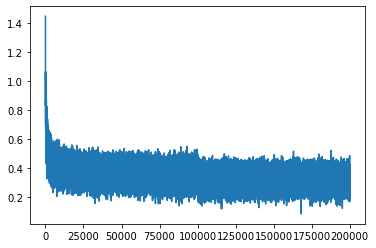

In [7]:
plt.plot(lossi)

In [8]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1  + b1
    #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    #hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1256096363067627
val 2.169816732406616


In [9]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1,block_size,n_embd)
        h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1) # concatenate the vectors
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

mora.
mayah.
see.
mel.
ryllo.
emmadiengrael.
adelyn.
elin.
shy.
jenreigh.
estana.
selyn.
malkia.
noshubergihamies.
kendreelynn.
nocoorius.
macder.
yaralyek.
yuma.
mysanyah.


## Fixing the initial loss
As can be seen in cell 17, we have a very high initial loss. <br>
We can address that by initializing our W to very low numbers and B to be zeros.

In [10]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.01 # init to very low numbers
b1 = torch.randn(n_hidden,                        generator=g) * 0 # init to 0
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # init to very low numbers
b2 = torch.randn(vocab_size,                      generator=g) * 0 # init to 0


parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


In [11]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
  # backward pass
    for p in parameters:
        p.grad = None
    
    loss.backward()
  
  # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

  # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    

      0/ 200000: 3.2970
  10000/ 200000: 2.1528
  20000/ 200000: 2.3148
  30000/ 200000: 2.4667
  40000/ 200000: 1.9351
  50000/ 200000: 2.4531
  60000/ 200000: 2.3086
  70000/ 200000: 2.0852
  80000/ 200000: 2.2690
  90000/ 200000: 2.1908
 100000/ 200000: 1.9008
 110000/ 200000: 2.2895
 120000/ 200000: 2.0100
 130000/ 200000: 2.4892
 140000/ 200000: 2.4859
 150000/ 200000: 2.2474
 160000/ 200000: 1.9452
 170000/ 200000: 1.7645
 180000/ 200000: 2.0616
 190000/ 200000: 1.8564


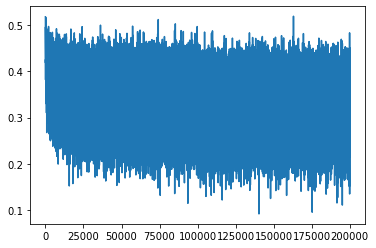

In [12]:
plt.plot(lossi)

In [13]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1  + b1
    #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    #hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.10659122467041
val 2.1391992568969727


(array([521.,  84.,  64.,  52.,  43.,  28.,  22.,  36.,  29.,  11.,  18.,
         33.,  24.,  44.,  35.,  45.,  44.,  73.,  85., 122., 153., 232.,
        269., 375., 694., 654., 384., 308., 215., 143.,  95.,  79.,  61.,
         41.,  58.,  36.,  36.,  38.,  26.,  26.,  33.,  36.,  34.,  44.,
         36.,  60.,  54.,  48., 110., 609.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

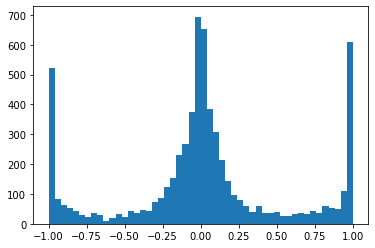

In [14]:
plt.hist(h.view(-1).tolist(), 50)

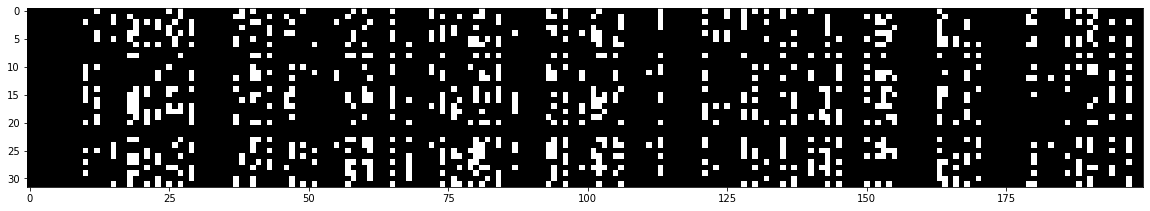

In [15]:
plt.figure(figsize = (20,10))
plt.imshow(h.abs() > 0.99, cmap = 'gray', interpolation = 'nearest')

White means 0 > 0.99. <br>
What we don't want even to see is vertical lines of white which means that the neuron is dead.

## Fixing saturated tanh
As can be seen in cell 40, there are a lot of tanh values of -1 and 1. <br>
It means that the gradients of these weights/biases are 0 thus killing the learning of gradient descent. <br>
What we want is as small as possible number of -1 or 1 tanh.<br><br>
Apparently, the initialization of weights and biases to a very low number helps answer this tanh saturation.<br>


### Kaiming init
What small values do we need to multiply our weight on? <br>
The answer is that it depends on the activation function we uses and if you want to dive deeper, you can see this documentation https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_ <br>
What it does is that it to keep the weight to be distributed as gaussian distribution with 0 mean and 1 stdev. <br>
A rule of thumb, just normalize the weight with sqrt(#number of input).

In [16]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 5/3/((n_embd * block_size)**0.5) # kaiming init
b1 = torch.randn(n_hidden,                        generator=g) * 0 # init to 0
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # init to very low numbers
b2 = torch.randn(vocab_size,                      generator=g) * 0 # init to 0


parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


In [17]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
  # backward pass
    for p in parameters:
        p.grad = None
    
    loss.backward()
  
  # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

  # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    

      0/ 200000: 3.3179
  10000/ 200000: 2.1904
  20000/ 200000: 2.3173
  30000/ 200000: 2.5320
  40000/ 200000: 1.9544
  50000/ 200000: 2.3148
  60000/ 200000: 2.3767
  70000/ 200000: 2.1201
  80000/ 200000: 2.3240
  90000/ 200000: 2.2239
 100000/ 200000: 1.8668
 110000/ 200000: 2.0755
 120000/ 200000: 1.9381
 130000/ 200000: 2.3580
 140000/ 200000: 2.0968
 150000/ 200000: 2.1690
 160000/ 200000: 1.7995
 170000/ 200000: 1.7266
 180000/ 200000: 1.9766
 190000/ 200000: 1.8363


In [18]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1  + b1
    #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    #hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0378525257110596
val 2.1075706481933594


We can see that the train and dev error is lower. However, the effect of kaiming init turns out not to be substantial enough in modern application of deep learning. Some of the cause is that are better innovation such as batch normalization.

### Batch Normalization
https://arxiv.org/abs/1502.03167 <br>
Goal : To have a gaussian distributed (0,1) h pre activation vector at initialization (h = X @ W + b) <br>
How : Instead of initializing the W to follow normal dist (0,1), we normalize the h to be distributed normally (0,1) <br><br>

h = gain * (h - h.mean) / (h.stdev + epsilon)  <br>
gain is a kind of weight that will be optimized as learning progressed <br>
epsilon is a very small number to prevent dividing by zero<br><br>
#### Implication (1)
However, it comes with a cost of losing parallelism because it needs to calculate the mean and the stdev of a batch.<br>
But, apparently it introduces a form of regularization that is beneficial to training neural network.

#### Implication (2)
Since we introduce mean and stdev of a batch, now the model expect batch instead of single observation. It is not possible to  feed a single data point. <br>
What we can do is calculate the running mean and stdev of the training dataset, and store that in variables that later can be used for prediction.

#### Implication (3)
Since batch normalization has its own bias, the bias from linear function before that is not useful. <br>
Thus, we can just not use it.

In [19]:
hpreact.shape

torch.Size([32, 200])

In [7]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 5/3/((n_embd * block_size)**0.5) # kaiming init
#b1 = torch.randn(n_hidden,                        generator=g) * 0 # init to 0 # not used due to bnbias
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # init to very low numbers
b2 = torch.randn(vocab_size,                      generator=g) * 0 # init to 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden)) # will be broadcasted to (batch_size, n_hidden)
bnbias = torch.zeros((1, n_hidden)) # will be broadcasted to (batch_size, n_hidden)
bnmean_running = torch.zeros((1, n_hidden)) # init of BatchNorm running mean with value of 0
bnstd_running = torch.ones((1, n_hidden)) # init of BatchNorm running stdev with value of 1

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

12097


In [8]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    
    # Linear layer
    hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
    
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / (bnstdi + 10e-5) + bnbias # 10e-5 is epsilon
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # -------------------------------------------------------------
    
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
  # backward pass
    for p in parameters:
        p.grad = None
    
    loss.backward()
  
  # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

  # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    

      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6414
 130000/ 200000: 1.9312
 140000/ 200000: 2.2232
 150000/ 200000: 2.0027
 160000/ 200000: 2.0996
 170000/ 200000: 2.4949
 180000/ 200000: 2.0198
 190000/ 200000: 2.1707


In [9]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 # + b1
    #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias # using BatchNorm running mean and stdev to calculate normalize
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0674147605895996
val 2.1056854724884033


In [27]:
# calibrate the batch norm at the end of training

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 # + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [28]:
bnmean

tensor([[-2.3951,  0.3697, -1.2721,  1.2946,  0.9557,  0.9956,  1.5505, -1.9209,
          1.1122,  1.2443, -1.8120, -2.7732,  0.0740, -0.6076,  0.4334, -0.6824,
          0.7747, -2.1874, -0.1997,  1.5906, -0.8759,  0.0856, -0.2509,  0.4103,
          1.0315,  1.6303,  1.1982,  0.9553,  0.3585,  1.9512, -0.0683, -1.2068,
         -0.1048, -0.2659, -0.4750, -1.4983, -2.6133,  0.0535, -0.0118,  0.6009,
         -0.2271, -0.8905, -0.2850, -0.1836,  0.6519,  0.8989,  1.5830, -0.3834,
          1.9893,  1.0678,  1.7158, -0.7877,  2.0548,  0.3595,  0.5521, -1.9211,
         -0.0324,  0.7199,  0.8939, -0.7949, -0.6655,  0.9819,  0.4984,  0.2978,
          1.1427,  1.6460, -1.3207,  2.4311, -0.5222,  0.4783, -1.0088,  0.2360,
          1.0445, -1.5622, -3.0713,  0.6018,  0.7533, -0.0513,  0.4650,  0.7591,
          0.2517,  1.2639,  1.4015,  0.5570, -0.2060, -0.0651, -1.3351,  0.5008,
          0.1291, -0.4667, -0.3976,  1.4660, -1.1291, -0.8737, -0.9942,  0.2943,
         -0.3022,  0.1406,  

In [29]:
bnmean_running

tensor([[-2.4077e+00,  3.7337e-01, -1.2685e+00,  1.2964e+00,  9.6899e-01,
          9.8380e-01,  1.5425e+00, -1.9248e+00,  1.1059e+00,  1.2246e+00,
         -1.8298e+00, -2.7719e+00,  7.1532e-02, -6.1835e-01,  4.3356e-01,
         -6.6879e-01,  7.7057e-01, -2.1872e+00, -2.1863e-01,  1.5705e+00,
         -8.6613e-01,  1.0756e-01, -2.3924e-01,  4.1451e-01,  1.0353e+00,
          1.6322e+00,  1.1983e+00,  9.5769e-01,  3.5318e-01,  1.9481e+00,
         -8.0590e-02, -1.2022e+00, -9.7799e-02, -2.6641e-01, -4.7091e-01,
         -1.4911e+00, -2.6119e+00,  4.7215e-02,  2.7277e-06,  6.0425e-01,
         -2.3627e-01, -9.1304e-01, -2.8285e-01, -1.7863e-01,  6.5149e-01,
          9.0377e-01,  1.5863e+00, -3.9478e-01,  1.9727e+00,  1.0565e+00,
          1.7168e+00, -7.9497e-01,  2.0449e+00,  3.5583e-01,  5.5006e-01,
         -1.9196e+00, -3.1615e-02,  7.1290e-01,  9.0182e-01, -7.9925e-01,
         -6.7679e-01,  9.6936e-01,  4.8914e-01,  2.9614e-01,  1.1422e+00,
          1.6289e+00, -1.3292e+00,  2.

In [10]:
# SUMMARY + PYTORCHIFYING -----------

In [12]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5 # weight initialization; might omit it since it is already addressed by BatchNorm
        self.bias = torch.zeros(fan_out) if bias else None
  
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
  
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
    def __init__(self, dim, eps=1e-5, momentum=0.1): # use a very small momentum value if batch size is small
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim) # weight of BatchNorm activation
        self.beta = torch.zeros(dim) # bias of BatchNorm activation
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
  
    def __call__(self, x):
    # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta # for tracking stats
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
  
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    #layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1.0 #5/3 # might omit it since it is already addressed by BatchNorm


parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

47024


In [13]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
  
  # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

  # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000:
        break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2870


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.78%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.56%
layer 8 (      Tanh): mean -0.00, std 0.65, saturated: 2.25%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.69%
layer 14 (      Tanh): mean +0.00, std 0.65, saturated: 1.88%


Text(0.5, 1.0, 'activation distribution')

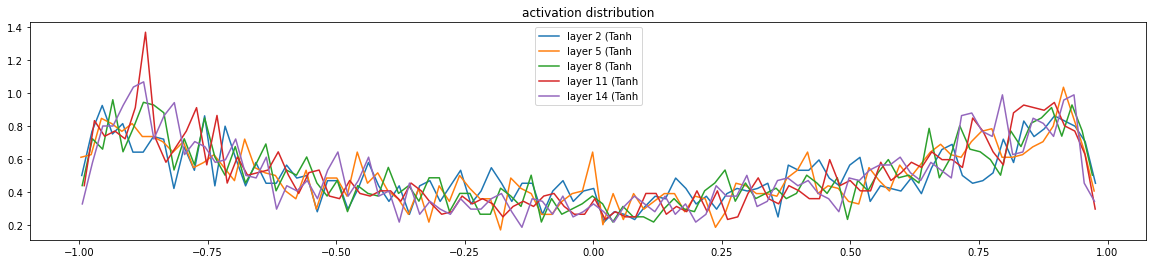

In [14]:

# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

Things to look at cell 14 graph: <br>
1. Activation value is not squashed (majority close to 0) or explode (majority close to 1 or -1)
2. Similar mean, std, and % saturated

layer 2 (      Tanh): mean -0.000000, std 2.640701e-03
layer 5 (      Tanh): mean -0.000000, std 2.245583e-03
layer 8 (      Tanh): mean +0.000000, std 2.045740e-03
layer 11 (      Tanh): mean +0.000000, std 1.983132e-03
layer 14 (      Tanh): mean +0.000000, std 1.952381e-03


Text(0.5, 1.0, 'gradient distribution')

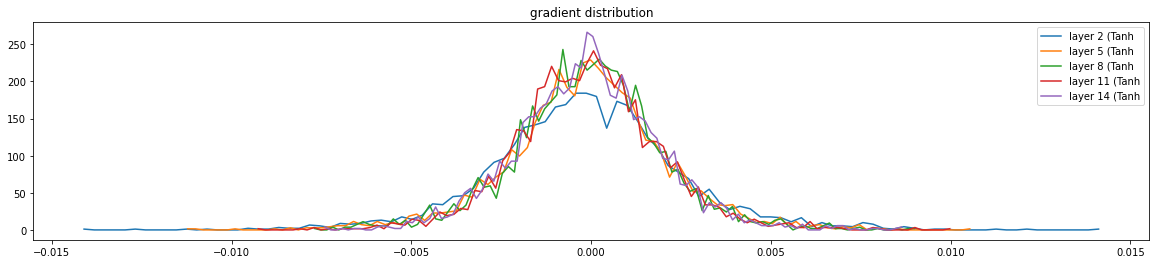

In [15]:

# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

Things to look at cell 15 graph: <br>
1. Gradient has similar stdev, if it expands -> too low of learning rate; if it shrinks -> too high of learning rate 
2. Similar mean and std

weight   (27, 10) | mean -0.000000 | std 8.020528e-03 | grad:data ratio 8.012624e-03
weight  (30, 100) | mean +0.000246 | std 9.241068e-03 | grad:data ratio 4.881086e-02
weight (100, 100) | mean +0.000113 | std 7.132872e-03 | grad:data ratio 6.964612e-02
weight (100, 100) | mean -0.000086 | std 6.234297e-03 | grad:data ratio 6.073733e-02
weight (100, 100) | mean +0.000052 | std 5.742180e-03 | grad:data ratio 5.631476e-02
weight (100, 100) | mean +0.000032 | std 5.672202e-03 | grad:data ratio 5.570122e-02
weight  (100, 27) | mean -0.000082 | std 1.209415e-02 | grad:data ratio 1.160105e-01


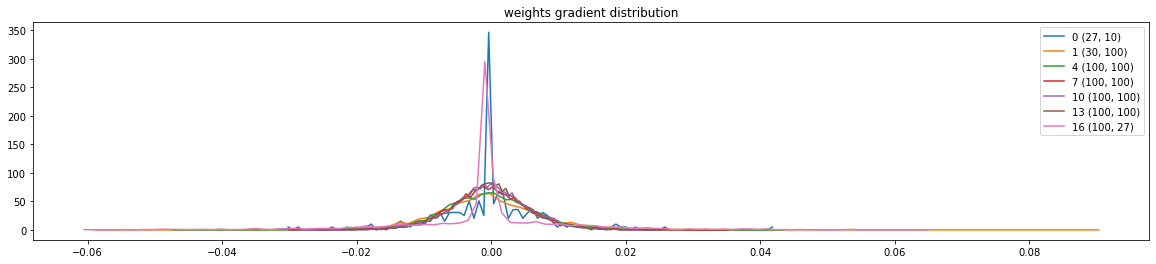

In [16]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

Things to look at cell 16 graph: <br>
1. Similar grad to data ratio; if not, some are learning faster than others
2. Don't want big difference in stdev

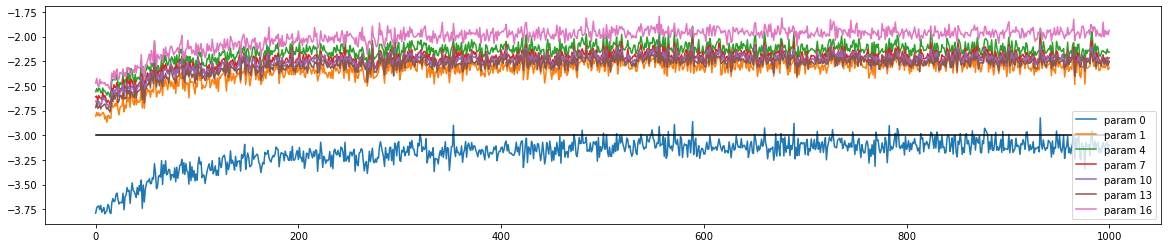

In [17]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

Things to look at cell 17 graph: <br>
1. Similar update rate; if not, some are learning faster than others
2. Lower than 10e-3 or -3 in the plot means a slow learning rate -> need to bump up
3. Higher than 10e-3 or -3 in the plot means a fast learning rate -> need to tone down